# Introduction
In this post, I demonstrate two broad techniques for engineering numeric features in the HDB resale flat dataset: target transformation and binning. The objective for transforming numeric features is to convert them into a form that facilitates machine learning.  

In [1]:
# Import modules
from IPython.display import Image  
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
from scipy import misc
from scipy import stats
import seaborn.apionly as sns
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import warnings

# Settings
%matplotlib inline
warnings.filterwarnings('ignore')

# Read data
hdb = pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2015-onwards.csv')

## Numeric Features in the Dataset
To recap, there are four numeric features in the dataset: our target `resale_price`, and predictors `floor_area_sqm`, `lease_commence_date`, and `remaining_lease`. Let's extract these from the dataset and plot a correlation matrix:

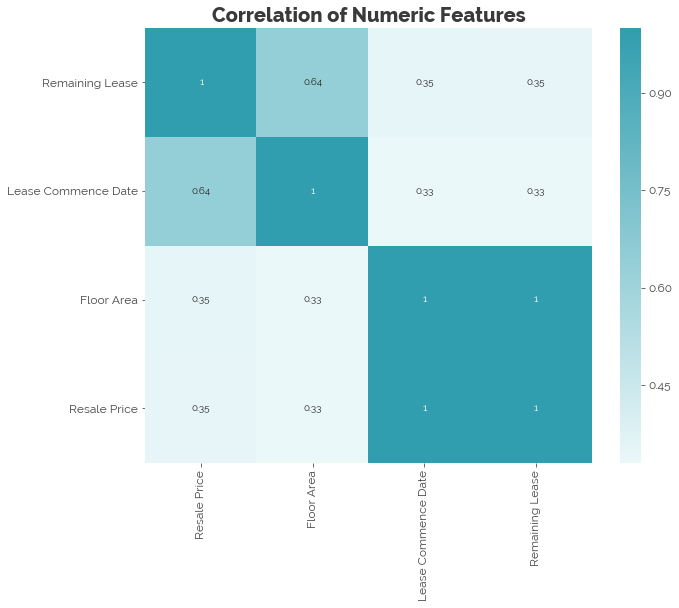

In [2]:
# Extract data
df = hdb[['resale_price', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease']]

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

We find that the lease commence date and the remaining lease are highly correlated. Hence, we can simply pick one of them. Let's keep the remaining lease because it provides better intuition than the year that the lease commenced.

In [3]:
# Drop lease commence date
df = df.drop('lease_commence_date', axis = 1)

# Two Techniques for Feature Generation

## 1. Transform the Target
We noted in our exploratory data analysis (EDA) phase that the distribution of the target (I'll refer to resale as "the target") was right skewed.

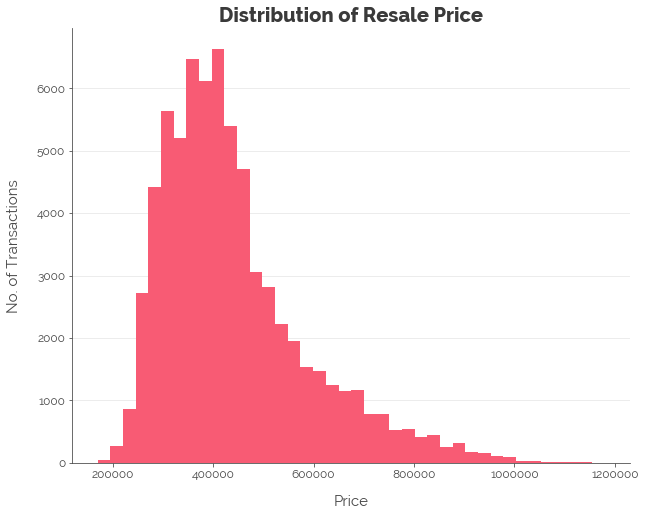

In [4]:
# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

Since regression models generally fit better when the target is normally distributed, we apply a log transformation. As shown below, the distribution appears more "normal" now.

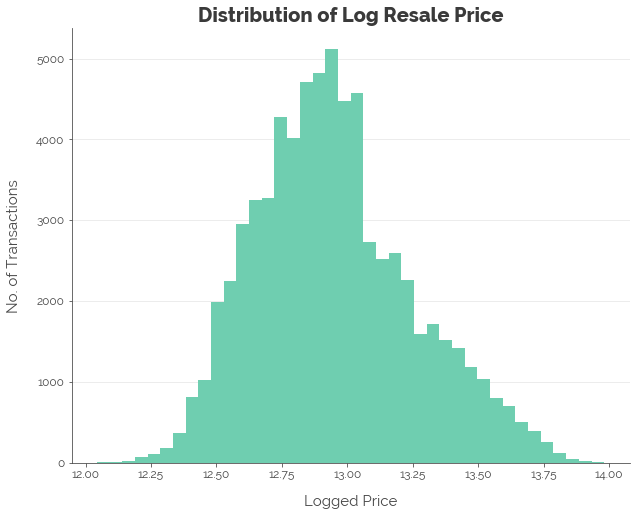

In [5]:
# Create log price variable
df['log_tgt'] = np.log(df.resale_price)

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

## 2. Binning
Binning is the process of splitting up a numeric feature at specified thresholds to get categories or bins. In this way, numeric features can be recoded as categorical features, where they can be processed further (more on this in the next post). The whole point of doing so is to facilitate the detection of patterns in the data. This is achieved by making sure that the bins we create have some relation to the target. For example, the bins can help our models to distinguish between low, medium, and high levels of the target. There are several techniques we can apply: 
  
1. Fixed-width binning
2. Quantile binning
3. Binning with decision trees  
  
### A. Fixed-width Binning
This concept is simple. We simply divide the 1-dimensional feature space into *n* equal parts. In English, we have markers that are equidistant. Let's use floor area as an example. 

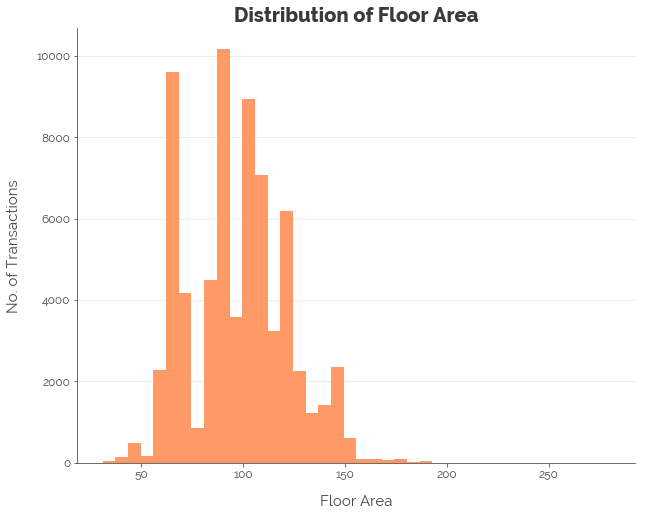

In [6]:
# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

Again, we note how right-skewed the data is. Performing the log transformation, we obtain a relatively "normal" distribution:

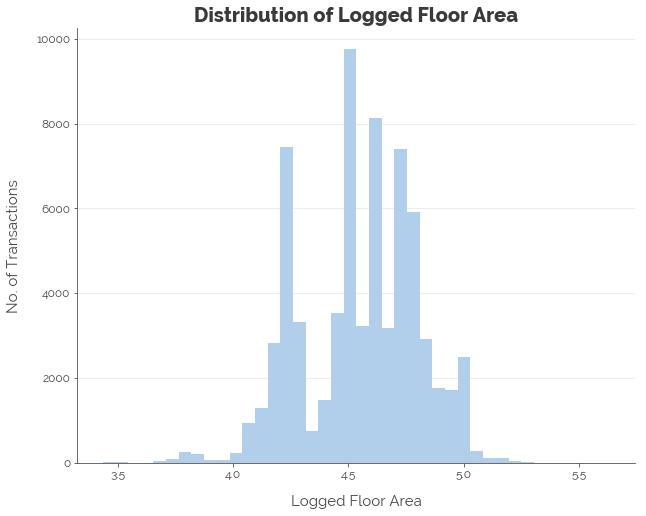

In [7]:
# Create logged floor area
df['log_floor_area'] = np.log(df.floor_area_sqm)

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

Now, suppose we want to divide the area into 4 equal parts. We know that the minimum logged floor area was 3.43 sqm, and the maximum was 5.63 sqm. Thus, each market must be about 0.55 sqm apart. Computing and superimposing these bins on the original graph, we have:

In [8]:
# Create quantile bins
df['log_floor_area_fwb'] = pd.cut(x=df.log_floor_area, bins=4)

In [9]:
# NOT RUN
df.log_floor_area_fwb.value_counts()

(4.534, 5.0846]    37050
(3.984, 4.534]     31626
(3.432, 3.984]       788
(5.0846, 5.635]      303
Name: log_floor_area_fwb, dtype: int64

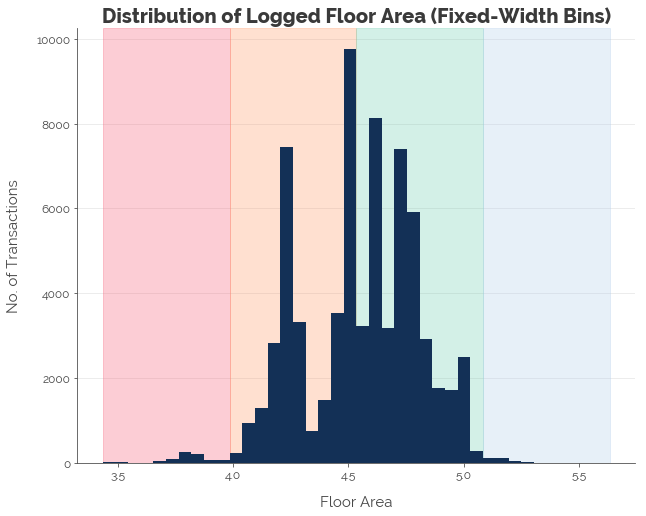

In [10]:
# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

That looks nice, bunt note that a large majority of observations will fall under bins 2 and 3 (orange and green). Increasing the number of fixed-width bins will not help much, because we will still have bins with large concentrations near the center and bins with low concentrations at the fringes. Hence, we turn to quantile binning.

### B. Quantile Binning
Quantile binning splits the data into *n* equal portions. In other words, we create bins with approximately the same number of observations in them. Let's split the data into four quantiles:

In [11]:
# Create quantile bins
df['log_floor_area_qb'] = pd.qcut(x=df.log_floor_area, q=4)

In [12]:
# NOT RUN
df.log_floor_area_qb.value_counts()

(4.564, 4.718]    17575
[3.434, 4.331]    17489
(4.331, 4.564]    17458
(4.718, 5.635]    17245
Name: log_floor_area_qb, dtype: int64

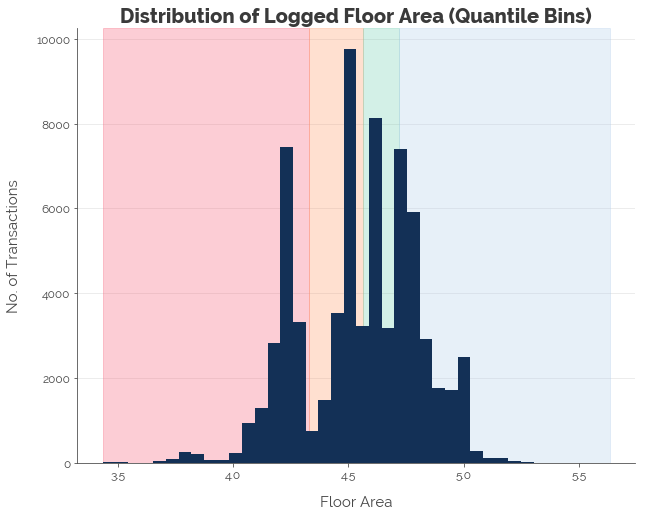

In [13]:
# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

The distances between the markers are no longer uniform now. But, we ensure that each bin has the same number of observations.

### Wait, What's the Point?
It's important to remember why we're binning in the first place: to help our models predict the target. Thus far, I've demonstrated two techniques for binning numeric data without any assessment of how good these binning configurations are. Let's evaluate them.

#### Fixed-Width Bins

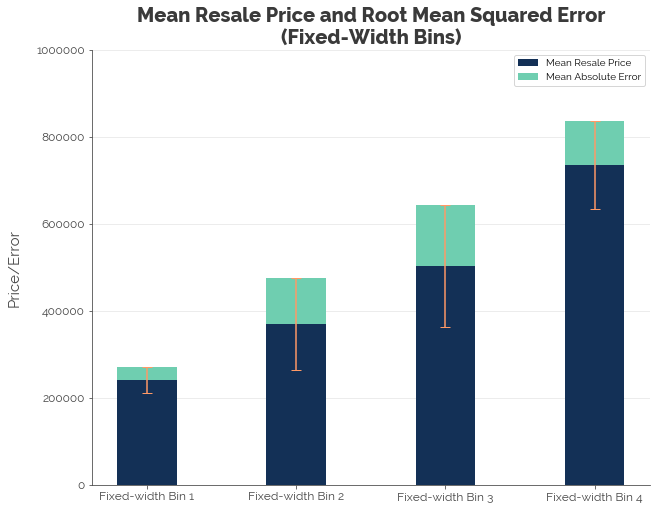

In [14]:
# Compute number of observations in each bin
eval_fw_bins = pd.DataFrame()
eval_fw_bins['count'] = df.log_floor_area_fwb.value_counts()

# Compute mean of resale price for each bin
eval_fw_bins['mean'] = df.groupby('log_floor_area_fwb').resale_price.mean()
df['fw_bins_mean'] = df.log_floor_area_fwb.astype('str').map(df.groupby('log_floor_area_fwb').resale_price.mean())

# Compute mean absolute error of resale price for each bin
df['fw_bins_sq_err'] = (df.resale_price - df.fw_bins_mean) ** 2
eval_fw_bins['rmse'] = np.sqrt(df.groupby('log_floor_area_fwb').fw_bins_sq_err.mean())

# Compute standard error
eval_fw_bins['std'] = df.groupby('log_floor_area_fwb').resale_price.std()

# Sort
eval_fw_bins = eval_fw_bins.sort_index()

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

#### Quantile Bins

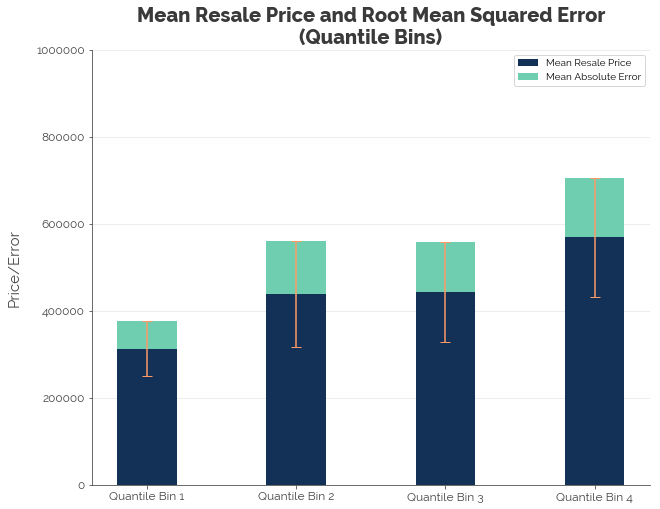

In [15]:
# Compute number of observations in each bin
eval_q_bins = pd.DataFrame()
eval_q_bins['count'] = df.log_floor_area_qb.value_counts()

# Compute mean of resale price for each bin
eval_q_bins['mean'] = df.groupby('log_floor_area_qb').resale_price.mean()
df['q_bins_mean'] = df.log_floor_area_qb.astype('str').map(df.groupby('log_floor_area_qb').resale_price.mean())

# Compute mean absolute error of resale price for each bin
df['q_bins_sq_err'] = (df.resale_price - df.q_bins_mean) ** 2
eval_q_bins['rmse'] = np.sqrt(df.groupby('log_floor_area_qb').q_bins_sq_err.mean())

# Compute standard error
eval_q_bins['std'] = df.groupby('log_floor_area_qb').resale_price.std()

# Sort
eval_q_bins = eval_q_bins.sort_index()

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

In the two graphs above, the blue bars represent the average prices of flats in the respective bins. The green bars represent the root mean squared errors (RMSE) - the standard deviation of prediction errors. The orange bar represents one standard deviation above and below the mean.  
  
First, we note that the trend in mean resale price is as expected: it increases with floor area. Second, we find that the RMSEs for both binning configurations are still fairly large. The only reason why RMSE is smaller for Bins 1 and 4 for the fixed-width configuration is that the bins contain much fewer observations. It is difficult to decide which of the two configurations would be more useful for predicting the target. A better way to optimise binning based on RMSE would be decision trees.

### C. Binning with Decision Trees
Decision trees give us a set of rules for splitting a dataset into discrete bins. In our case, we have a data subset with just resale prices and floor area. Therefore, the algorithm will split the floor area feature based on variance (or MSE) in resale prices. Note that we don't need to use the logged values because trees are sensitive only to the **order** of the features. For example, splitting logged floor area at 4.56 sqm is the same as splitting floor area at 96 sqm: the algorithm would be splitting floor area at the median.  
  
The first thing we need to do is extract the target (resale prices) and the sole feature: floor area.

In [16]:
# Separate data
y_train = df.resale_price
X_train = df[['floor_area_sqm']]

Next, we fit a decision tree to the data. We must ensure that the algorithm creates bins that are not too narrowly defined. The problem with extremely small bins is that new, unseen data are also subject to noise, and may therefore not fall into bins in a way that would help us to improve our predictions. We therefore need to (1) limit tree depth and (2) demand sufficiently large leaf (terminal) nodes. The parameters I chose were:  
  
1. **criterion = 'mse':** MSE stands for mean squared error. This parameter tells the model to minimise variance or L2 loss.
2. **max_depth = 4:** Maximum depth controls the size of the tree in terms of the number of levels. For example, a family tree with (0) grandparents, (1) parents, (2) children, and (3) grandchildren has a depth of 3.
3. **min_samples_leaf = 6500:** This parameter sets the minimum number of observations in the terminal nodes of the tree. I set it at slightly less than 10% of the number of observations to ensure that the bins are sufficiently large.
4. **random_state = 123:** Just a random number to reproduce the same results.  
  
I have left all other parameters as the defaults. See the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) for more details.

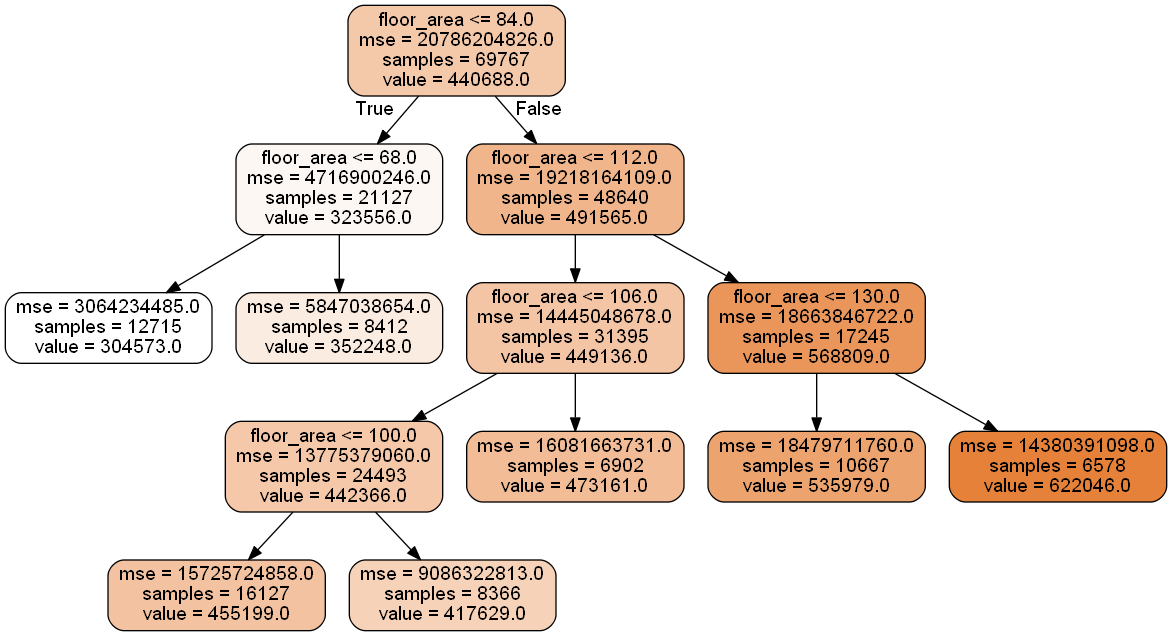

In [17]:
# Configure decision tree regressor
dt_model = DecisionTreeRegressor(
    criterion = 'mse',
    max_depth = 4,
    min_samples_leaf = 6500,
    random_state = 123
)

# Fit data
dt_model.fit(X_train, y_train)

# Plot
dot_data = tree.export_graphviz(
    dt_model, feature_names=['floor_area'],
    out_file=None, filled=True,
    rounded=True, precision = 0
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png(), width = 750)

Given the parameters above, the decision tree gives us 6 bins ranging in size from 6.5k to 16k observations. In each cell, `samples` states the number of observations, and `value` states the average price of flats in that node or bin.
  
1. **Bin 1:** Floor area less than 68 sqm.
2. **Bin 2:** Floor area of 68-84 sqm.
3. **Bin 3:** Floor area of 84-100 sqm.
4. **Bin 4:** Floor area of 100-106 sqm.
5. **Bin 5:** Floor area of 106-112 sqm.
6. **Bin 6:** Floor area of 112-130 sqm.
7. **Bin 7:** Floor area of 130 sqm or more.
  

In [18]:
# Extract data
dtree_means = [304573, 352248, 455199, 417629, 473161, 535979, 622046]
dtree_rmse = np.sqrt([3064234485, 5847038654, 15725724858, 9086322813, 1608166731, 18479711760, 14380391098])

Reproducing a similar chart for the decision tree bins, we see that, like the other binning configurations, the RMSE in each bin is still high. However, we have an interesting finding: Bin 3 appears to contain flats with a higher average price despite having a smaller floor area than Bin 4! This could give us some interesting results in the modeling phase.

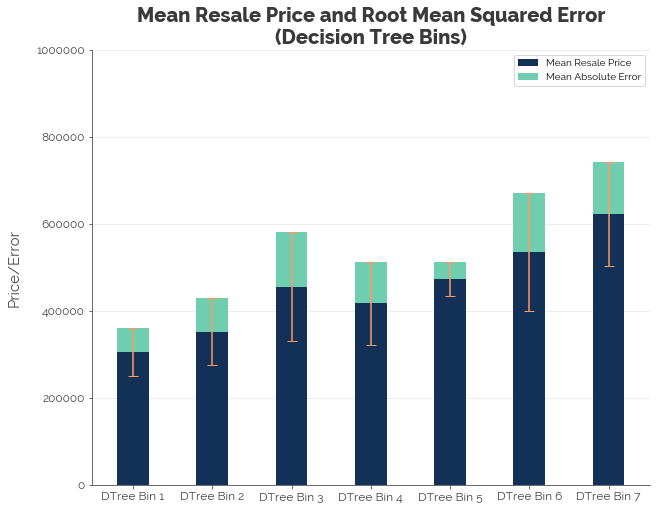

In [19]:
# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

### Selecting a Binning Method
Here's the quick, short, and correct answer: there is no quick, short, and easy way to select a binning method. The decision tree looks like it separates the data well, but it might end up giving the poorest prediction results. The only way to know which is the best method to use is to treat this as a hyperparameter in the pipeline. That is, we need to test many different binning configurations in our models and use cross validation to measure the prediction errors.

# What's Next?
In this post, I demonstrated two possible ways to transform numeric features in order to recode the data into a more useful form for machine learning. First, it is important to make the target as "normal" as possible. Second, it is useful to separate our numeric features into bins. I demonstrated fixed-width binning, quantile binning, and decision tree binning using the floor area feature. While the first two binning methods didn't generate any particularly interesting findings, the decision tree did. Yet, this doesn't make decision trees the method of choice. We will never know exactly which technique is the best until we validate our models.  
  
Are we done engineering features? **Far from it**. Binning numeric features essentially converts them into **categorical features**, and there are many more ways to transform them. Some techniques even involve converting categorical features back into numeric features! I'll save engineering of categorical features for another post.